# Machine Learning Assignment Homework 3: Support Vector Machine

## Introduction
In this notebook, we will create a use university application data for the purpose of admission classification using Support Vector Machine.  
The notebook will cover the following major steps:
- Data Processing
- Model Initialization
- Feature Selection and Model Training
- Identifying Support Vectors for each model and feature combination
- Result Visualization
- Result Analysis
- Inference

## (a) Data Pre-processing

### Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Current working directory
cwd = os.getcwd()

# Relative paths
data_train_path = os.path.join(cwd, 'data_train-2.csv')
data_test_path = os.path.join(cwd, 'data_test-2.csv')

# Load the training data
data_train = pd.read_csv(data_train_path)

# Load the test data
data_test = pd.read_csv(data_test_path)

We have used the `pandas` library and the `read_csv` function to load the train and test datasets.

In [2]:
# Display the first 5 rows
data_train.head()

,Unnamed: 0,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,0,109,331,116,5,5.0,5.0,9.38,1,0.93
1,1,346,316,98,1,1.5,2.0,7.43,0,0.49
2,2,99,332,119,4,5.0,4.5,9.24,1,0.90
3,3,210,301,104,3,3.5,4.0,8.12,1,0.68
4,4,242,317,103,2,2.5,2.0,8.15,0,0.65


In [3]:
# Print the shape of the data
print(f"\nShape of the training data: {data_train.shape}")
print(f"Column names in training data: {data_train.columns.to_list()}")

print(f"\nShape of the test data: {data_test.shape}")
print(f"Column names in test data: {data_test.columns.to_list()}")


Shape of the training data: (320, 10)
Column names in training data: ['Unnamed: 0', 'Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']

Shape of the test data: (80, 9)
Column names in test data: ['Unnamed: 0', 'Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']


### Data Cleaning

In [4]:
# Drop the 'Unnamed: 0' index column and 'Serial No.' column
data_train.drop(columns=['Unnamed: 0', 'Serial No.'], inplace=True)
data_test.drop(columns=['Unnamed: 0', 'Serial No.'], inplace=True)

# Check for missing values
missing_values = data_train.isnull().sum()
print("Number of missing values for each column in the training data:")
print(missing_values)
print(f"Total number of missing values in the train dataset: {missing_values.sum()}\n")

missing_values = data_test.isnull().sum()
print("Number of missing values for each column in the test data:")
print(missing_values)
print(f"Total number of missing values in the test dataset: {missing_values.sum()}")

Number of missing values for each column in the training data:
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64
Total number of missing values in the train dataset: 0

Number of missing values for each column in the test data:
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64
Total number of missing values in the test dataset: 0


We see there are no missing values, so we don't need to drop any rows from our dataset.

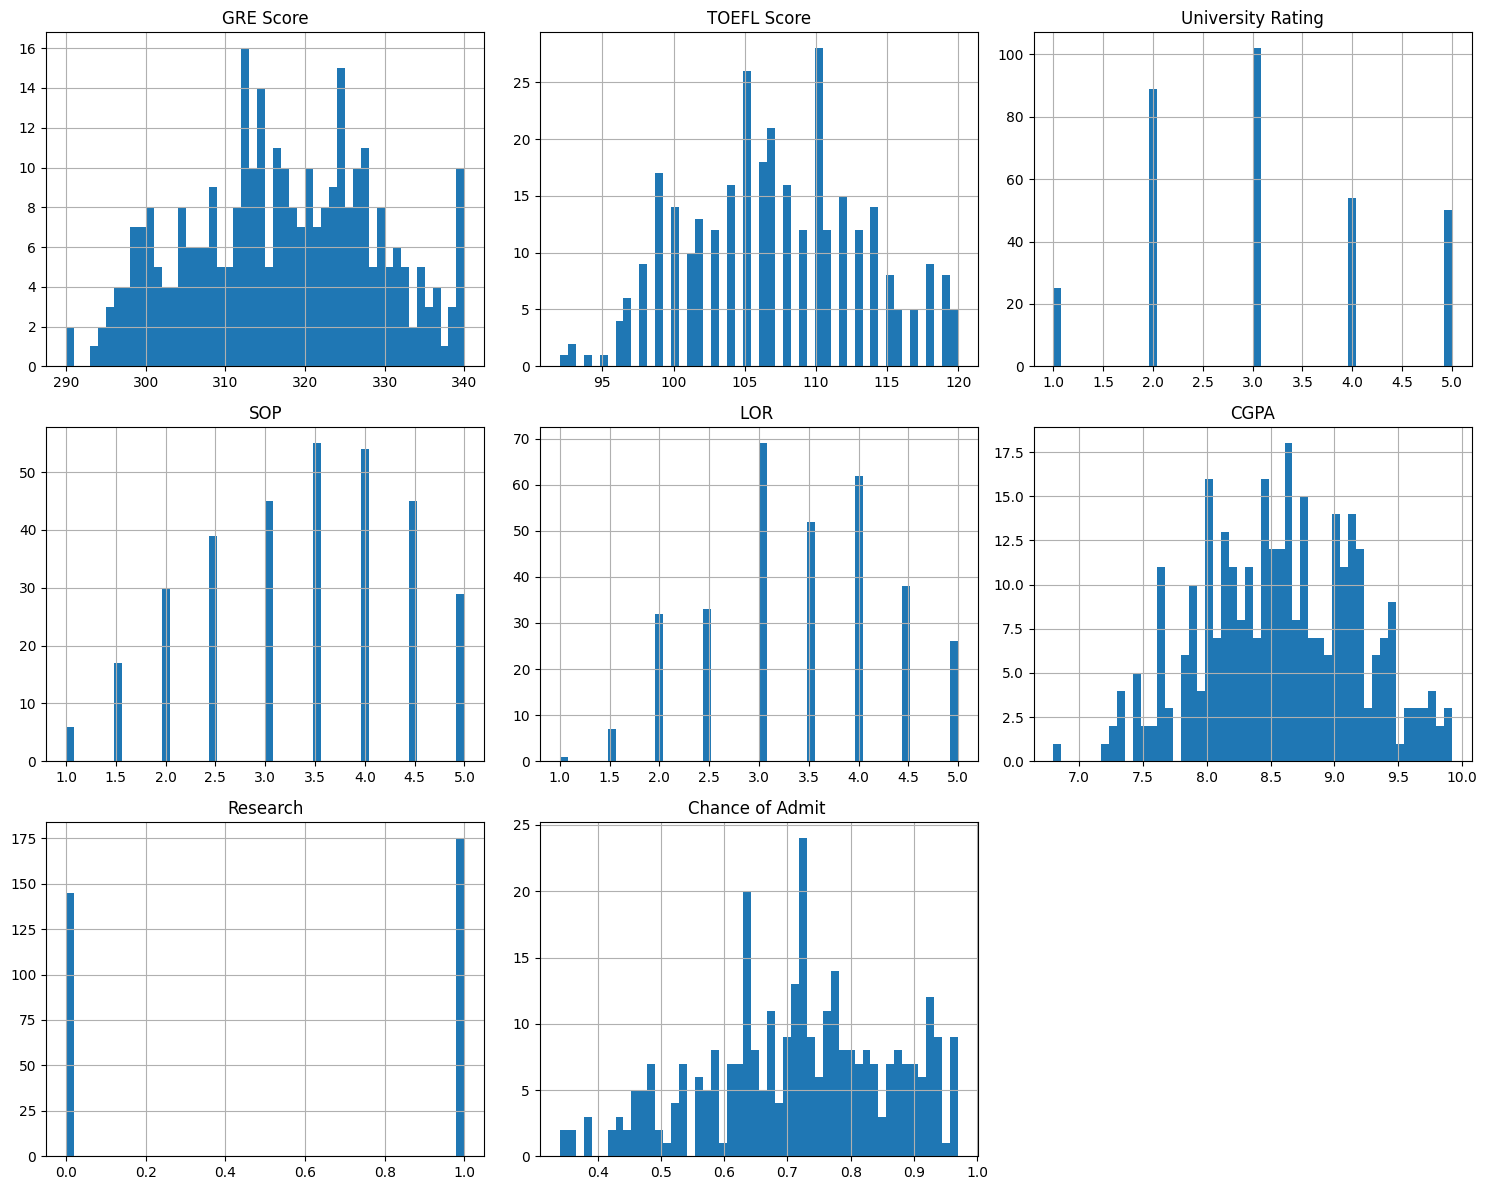

In [5]:
import matplotlib.pyplot as plt

# Plot histograms for all features
data_train.hist(bins=50, figsize=(15, 12))
plt.tight_layout()
plt.show()

### Binary Label Column

We create a binary label based on the column "Chance of Admit".  
We convert any values bigger than the median to 1 and 0 otherwise.

In [6]:
def create_binary_label(df: pd.DataFrame, column: str) -> pd.DataFrame:
    '''
    Convert the values in the specified column to binary labels:
    - Values greater than the median will be labeled as 1.
    - Values less than or equal to the median will be labeled as 0.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name based on which the binary label is created.

    Returns:
        pd.DataFrame: DataFrame with an additional binary label column.
    '''
    median_value = df[column].median()
    df['binary_label'] = np.where(df[column] > median_value, 1, 0)
    return df

data_train = create_binary_label(data_train, column='Chance of Admit ')
data_train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,binary_label
0,331,116,5,5.0,5.0,9.38,1,0.93,1
1,316,98,1,1.5,2.0,7.43,0,0.49,0
2,332,119,4,5.0,4.5,9.24,1,0.90,1
3,301,104,3,3.5,4.0,8.12,1,0.68,0
4,317,103,2,2.5,2.0,8.15,0,0.65,0


### Data Transformation
Normalization: I use standardization (Z-score normalization) to ensure all features have the same scale, making the mean of each feature 0 and the standard deviation 1. This ensures that no feature dominates the model due to it's scale. 

In [7]:
def normalize_features(X: np.ndarray) -> np.ndarray:
    '''
    Normalize the feature data to have a mean of 0 and standard deviation of 1.

    Parameters:
        X (np.ndarray): Feature data to be normalized.

    Returns:
        np.ndarray: Normalized feature data.
    '''
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

### Data Split

In [8]:
def split_data(df: pd.DataFrame, features: list, label: str, test_size: float = 0.2, random_state: int = 42) -> tuple:
    '''
    Split the data into training and testing sets.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        features (list): List of column names to use as features.
        label (str): The column name for the label.
        test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
        random_state (int): Seed for reproducibility (default is 42).

    Returns:
        tuple: X_train, X_test, y_train, y_test (numpy arrays)
    '''
    X = df[features].values
    y = df[label].values
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

- The `train_test_split()` function from `sklearn.model_selection` is used to split the training data into training and validation sets.
- `test_size=0.2` specifies that 20% of the data should be used for validation.
- `random_state=42` ensures the results are reproducible by setting a fixed seed for the random number generator.

## (b) Model Initialization

Next, we initialize 3 different SVM models with the following kernels
1. Linear kernel
2. RBF kernel
3. Polynomial (degree 3) kernel

In [9]:
model_linear = SVC(kernel = 'linear')
model_rbf = SVC(kernel = 'rbf')
model_poly = SVC(kernel = 'poly', degree = 3)

## (c) Feature Selection and Model Training

In [10]:
def train_svm_model(X_train: np.ndarray, y_train: np.ndarray, kernel: str = 'linear') -> SVC:
    '''
    Train an SVM model using the specified kernel.

    Parameters:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        kernel (str): The kernel type to be used in the algorithm (default is 'linear').
    '''
    if kernel == 'poly':
        model = SVC(kernel=kernel, degree=3)
    else:
        model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    return model

In [11]:
feature_combinations = [
        ['CGPA', 'SOP'],
        ['CGPA', 'GRE Score'],
        ['SOP', 'LOR '],
        ['LOR ', 'GRE Score']
    ]

kernels = ['linear', 'rbf', 'poly']

trained_models = {}
stored_data = {}

for features in feature_combinations:
    X_train, X_val, y_train, y_val = split_data(data_train, features, 'binary_label')
    X_train = normalize_features(X_train)
    X_val = normalize_features(X_val)
    
    for kernel in kernels:
        model = train_svm_model(X_train, y_train, kernel=kernel)
        trained_models[(kernel, tuple(features))] = model
        stored_data[(kernel, tuple(features))] = (X_train, y_train)

In this part, we train each SVM model with the specified kernels on the four different feature combinations. We standardize the features for each combination to enhance model performance. The trained models are stored in a dictionary for easy access in the next parts.

## (d) Support Vectors

In [12]:
for (kernel, features), model in trained_models.items():
    support_vectors = model.support_vectors_
    support_vectors_per_class = model.n_support_

    print(f"{kernel} kernel with features {features}")
    print(f"Total Support Vectors: {len(support_vectors)}")
    print(f"Support Vectors per Class: {dict(enumerate(support_vectors_per_class))}")
    print("Support Vectors:\n", support_vectors, "\n")

linear kernel with features ('CGPA', 'SOP')
Total Support Vectors: 87
Support Vectors per Class: {0: 44, 1: 43}
Support Vectors:
 [[ 0.05401792  0.11593445]
 [-0.10566554 -0.35516426]
 [ 0.19773304  0.58703316]
 [ 0.26160642 -0.35516426]
 [ 0.11789131  1.52923059]
 [ 0.149828   -1.29736169]
 [ 0.75662516  1.05813188]
 [-0.18550727 -0.35516426]
 [ 0.08595461 -0.82626298]
 [-0.04179216  0.11593445]
 [ 0.72468847 -0.35516426]
 [ 0.34144816  0.58703316]
 [-0.42503247  0.11593445]
 [-0.265349    0.58703316]
 [-0.10566554  0.11593445]
 [-0.5048742   0.58703316]
 [ 0.16579635  0.58703316]
 [-0.0577605   0.11593445]
 [-0.58471593  0.58703316]
 [ 0.00611288 -0.35516426]
 [-0.04179216 -0.82626298]
 [-0.18550727  0.11593445]
 [-0.68052601  1.05813188]
 [-0.13760223 -0.35516426]
 [-0.0577605   0.11593445]
 [ 0.05401792  0.11593445]
 [ 0.30951146 -0.82626298]
 [-0.15357058  1.05813188]
 [ 0.11789131  0.11593445]
 [ 0.18176469 -0.82626298]
 [-0.45696916  0.11593445]
 [-0.18550727 -0.35516426]
 [ 0.3

For each SVM model and feature combination, we print the actual support vectors along with their counts per class (0 and 1). This provides insight into the specific data points that contribute to defining the decision boundary for each model. The support vectors are printed, and `n_support_` is used to obtain the count per class.


## (e) Result Visualization

Define a function to plot a classifier with support vectors.

In [13]:
def plot_svc(svc, X, y, features, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    scatter = plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)

    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(features[0])
    plt.ylabel(features[1])

    handles = scatter.legend_elements()[0]
    labels = [f'Class {int(cls)}' for cls in np.unique(y)]
    
    plt.legend(handles, labels, title="Classes", loc='upper left')

    plt.show()


linear kernel with features ('CGPA', 'SOP')
Number of support vectors: 87


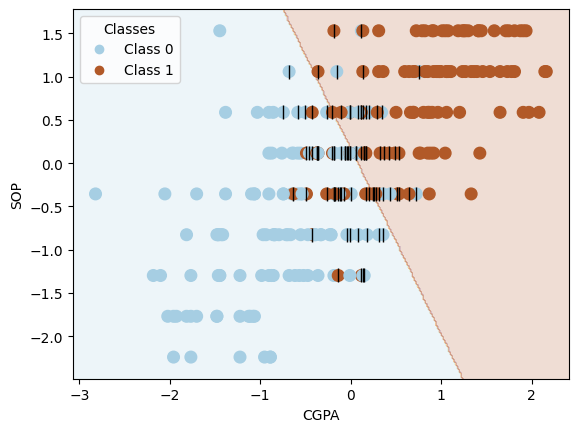

rbf kernel with features ('CGPA', 'SOP')
Number of support vectors: 95


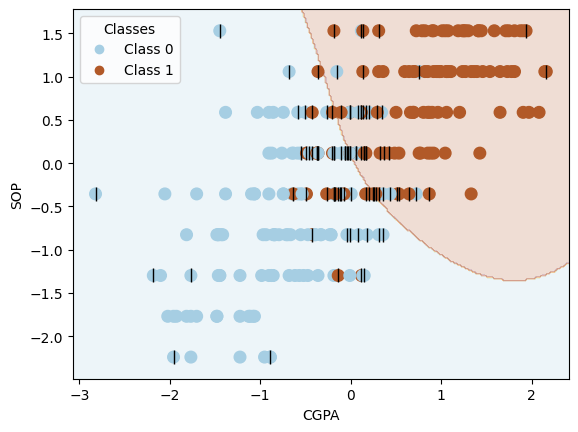

poly kernel with features ('CGPA', 'SOP')
Number of support vectors: 116


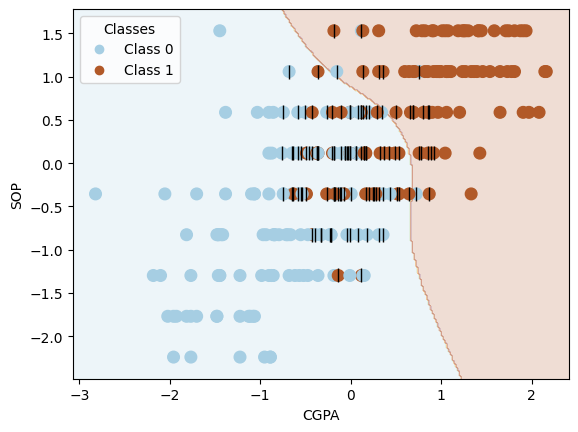

linear kernel with features ('CGPA', 'GRE Score')
Number of support vectors: 85


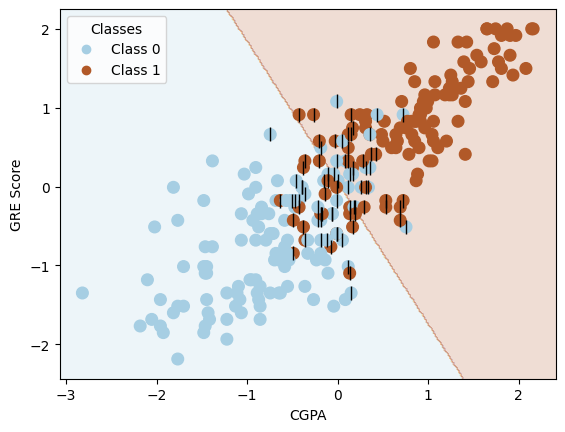

rbf kernel with features ('CGPA', 'GRE Score')
Number of support vectors: 93


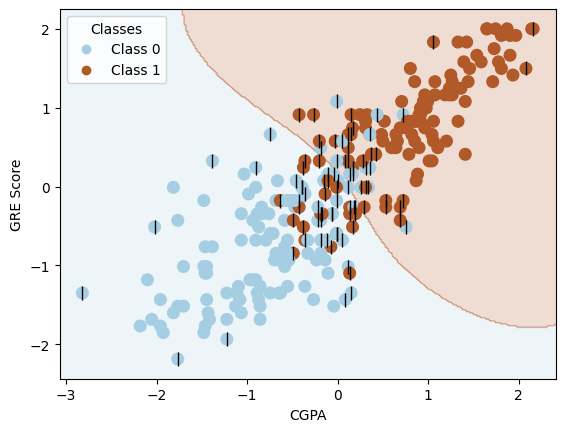

poly kernel with features ('CGPA', 'GRE Score')
Number of support vectors: 114


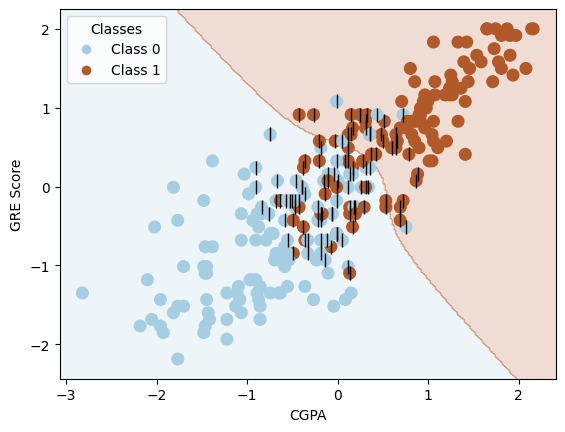

linear kernel with features ('SOP', 'LOR ')
Number of support vectors: 115


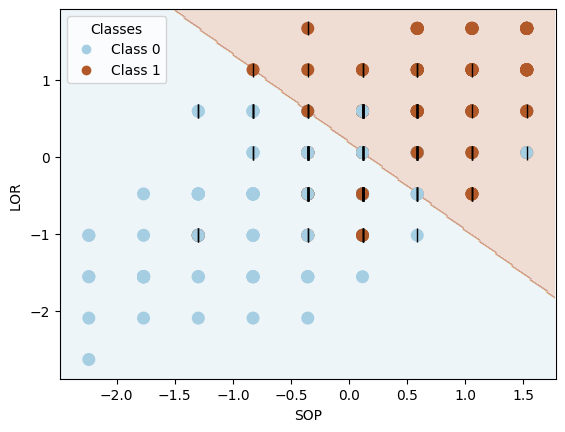

rbf kernel with features ('SOP', 'LOR ')
Number of support vectors: 119


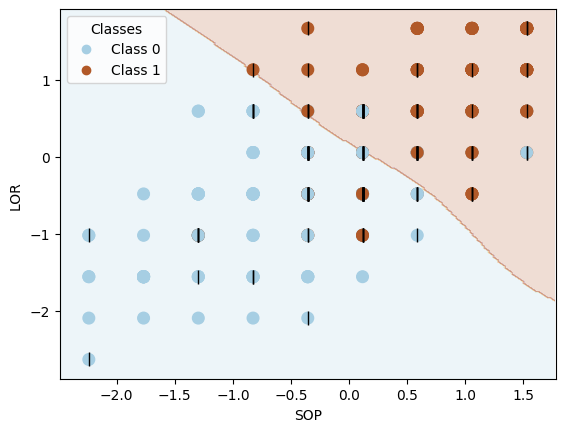

poly kernel with features ('SOP', 'LOR ')
Number of support vectors: 138


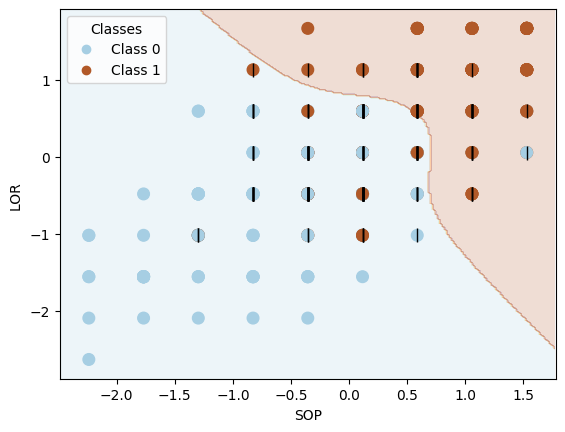

linear kernel with features ('LOR ', 'GRE Score')
Number of support vectors: 89


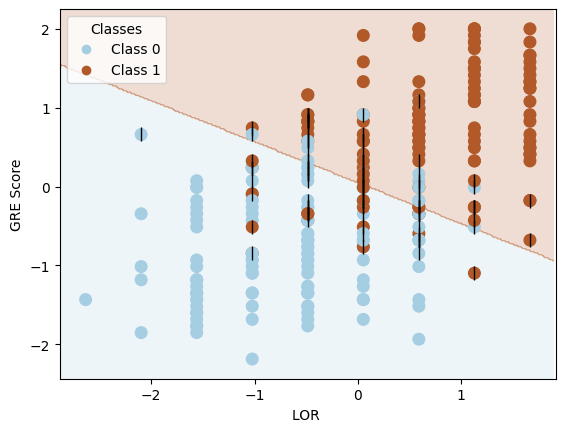

rbf kernel with features ('LOR ', 'GRE Score')
Number of support vectors: 95


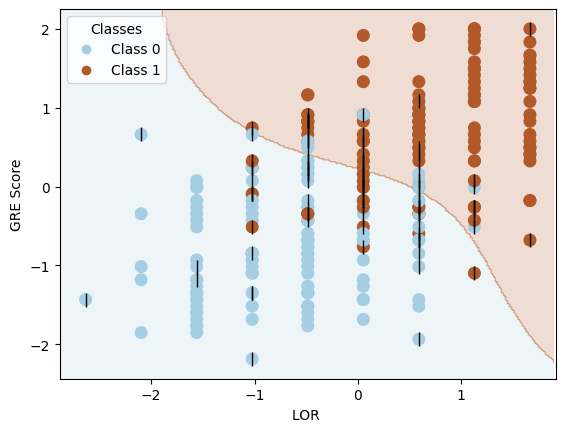

poly kernel with features ('LOR ', 'GRE Score')
Number of support vectors: 117


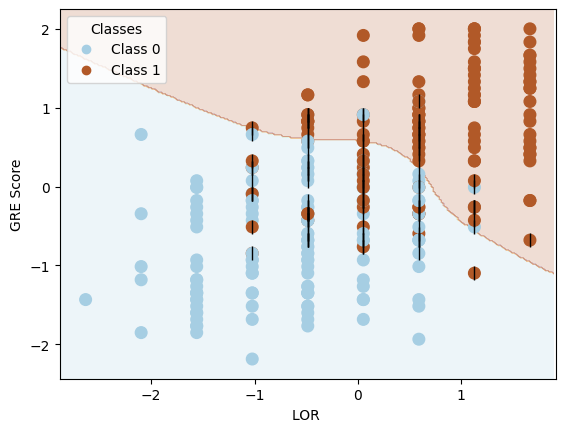

In [14]:
for (kernel, features), model in trained_models.items():
    X_train, y_train = stored_data[(kernel, features)]
    print(f"{kernel} kernel with features {features}")
    print('Number of support vectors:', model.support_.size)
    plot_svc(model, X_train, y_train, features)


For each kernel and feature combination, we visualize the predictions on the training set using the models trained in part (c). Each plot shows the decision boundary with different colors representing the predicted classes (admit or not admit). The legend indicates the class labels. This visualization helps to understand how well the model distinguishes between classes based on the training data.

Next, we visualise all the plots together to compare them visually for best classification.

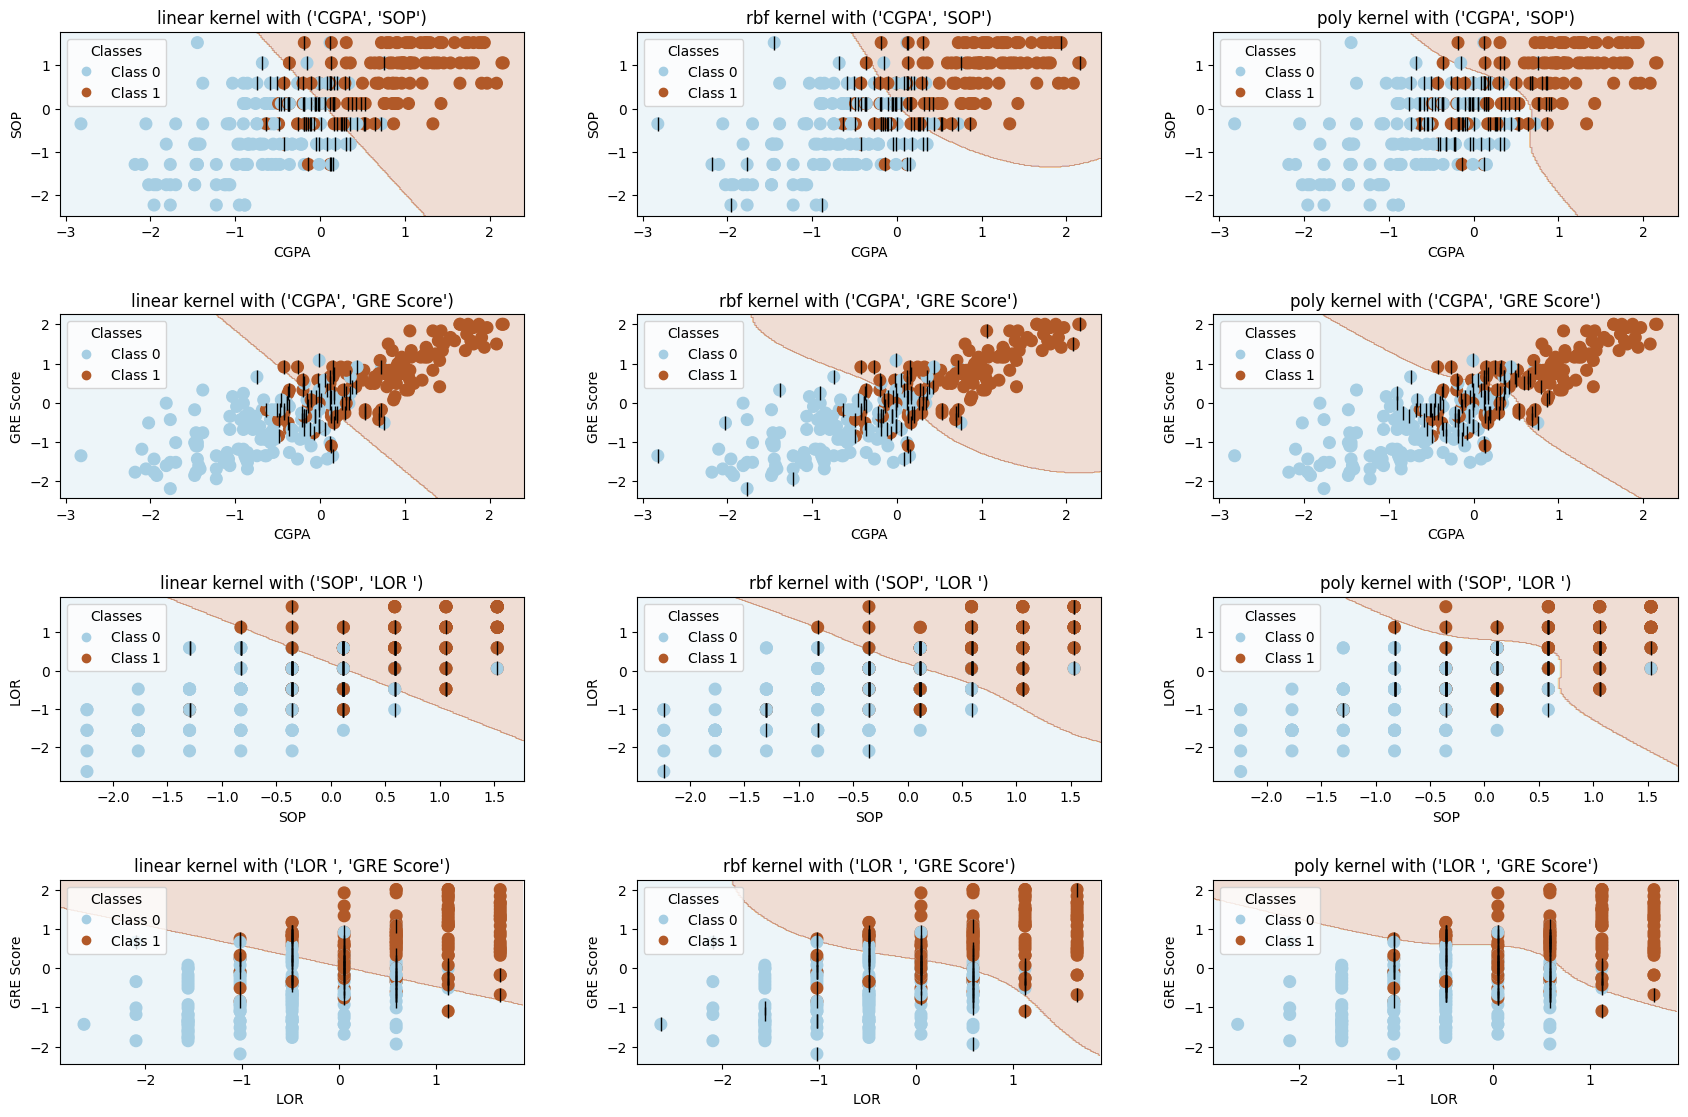

In [15]:
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
fig.tight_layout(pad=5.0)

for idx, ((kernel, features), model) in enumerate(trained_models.items()):
    X_train, y_train = stored_data[(kernel, features)]
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    x_min, x_max = X_train[:, 0].min() - 0.25, X_train[:, 0].max() + 0.25
    y_min, y_max = X_train[:, 1].min() - 0.25, X_train[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], s=70, c=y_train, cmap=plt.cm.Paired)

    sv = model.support_vectors_
    ax.scatter(sv[:, 0], sv[:, 1], c='k', marker='|', s=100, linewidths=1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_title(f'{kernel} kernel with {features}')

    handles = scatter.legend_elements()[0]
    labels = [f'Class {int(cls)}' for cls in np.unique(y_train)]
    ax.legend(handles, labels, title="Classes", loc='upper left')

plt.show()


## (f) Result Analysis

Just by looking at the figures we generated in the previous step, it looks like linear kernel with features ('CGPA', 'SOP') is giving the best classification result. The overlap between the two classes seems to be less.  
Similar classification result can also be seen by rbf kernel with features ('CGPA', 'SOP').  

Next, we will validate our model on the validation set and find the best performing combinations with respect to accuracy.

linear kernel with features ['CGPA', 'SOP']
Accuracy:  0.828125

rbf kernel with features ['CGPA', 'SOP']
Accuracy:  0.84375

poly kernel with features ['CGPA', 'SOP']
Accuracy:  0.78125

linear kernel with features ['CGPA', 'GRE Score']
Accuracy:  0.8125

rbf kernel with features ['CGPA', 'GRE Score']
Accuracy:  0.796875

poly kernel with features ['CGPA', 'GRE Score']
Accuracy:  0.796875

linear kernel with features ['SOP', 'LOR ']
Accuracy:  0.71875

rbf kernel with features ['SOP', 'LOR ']
Accuracy:  0.71875

poly kernel with features ['SOP', 'LOR ']
Accuracy:  0.65625

linear kernel with features ['LOR ', 'GRE Score']
Accuracy:  0.75

rbf kernel with features ['LOR ', 'GRE Score']
Accuracy:  0.734375

poly kernel with features ['LOR ', 'GRE Score']
Accuracy:  0.75

Best features:  ['CGPA', 'SOP']
Best kernel:  rbf
Best accuracy:  0.84375


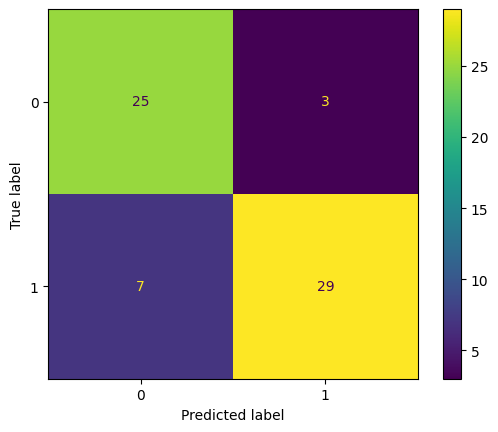

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_accuracy = 0
best_features = None
best_kernel = None
best_model = None
best_y_val = None
best_y_pred = None

for features in feature_combinations:
    X_train, X_val, y_train, y_val = split_data(data_train, features, 'binary_label')
    X_train = normalize_features(X_train)
    X_val = normalize_features(X_val)
    
    for model, model_name in zip([model_linear, model_rbf, model_poly], ['linear', 'rbf', 'poly']):
        model.fit(X_train, y_train)
        accuracy = model.score(X_val, y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = features
            best_kernel = model_name
            best_model = model
            best_y_val = y_val
            best_y_pred = model.predict(X_val)

        print(f"{model_name} kernel with features {features}")
        print('Accuracy: ', accuracy)
        print()

print('Best features: ', best_features)
print('Best kernel: ', best_kernel)
print('Best accuracy: ', best_accuracy)

cm = confusion_matrix(best_y_val, best_y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

## (g) Inference

We will use the best model combination obtained in the previous step to fit our model on the entire training set and predict the label of the test data.

In [17]:
X_train = data_train[best_features].values
y_train = data_train['binary_label'].values
X_test = data_test[best_features].values

X_train = normalize_features(X_train)
X_test = normalize_features(X_test)

best_model = train_svm_model(X_train, y_train, kernel=best_kernel)

y_pred = best_model.predict(X_test)
output_df = pd.DataFrame({'pred_svm': y_pred})
output_df.to_csv('Prakhar_Suryavansh_preds.csv', index=False)